Team HKV: Michael Keller, Henry Herzfeld, Yuri Villanueva

In this report, we attempt to implement RSA in Python. While the C library NTL is preferred by many for large number operations, we chose to invesigate whether Python can achieve the same or better performance than NTL using existing libraries or packages in conjunction with those that we create. Our results will be detailed in this document, in the hopes that they can be compared with those of other groups in order to make this determination.

# Naive RSA Decryption vs CRT Decryption

First, we were asked to investigate the difference in performance between a naive RSA implementation and an RSA implementation that uses the Chinese Remainder Theorem. 

First, we must perform key generation. We will create key sizes that are powers of 2 up to 8192 bits for comparison.

In [1]:
from RSA import RSA
from powmodn import rec_pow_mod_n, bit_pow_mod_n
from util import lcm, int2string, string2int
from math import gcd
from Crypto.Util import number
from rt import rt2, rt4, rt_average_2, rt_average_4
from inverse import rec_inverse
import pandas as pd
import sys

In [2]:
schemes=[]

scheme1 = RSA(powmodn=bit_pow_mod_n)
scheme2= RSA(powmodn=rec_pow_mod_n)
schemes.append(scheme1)
schemes.append(scheme2)

keys=[]

for scheme in schemes:
    for i in range (7, 13):
        key=(p, q, n, l, e, d, public_key, private_key)=scheme.generate_keys(bit_length=2**i)
        list(key)
        keys.append(key)

RSA scheme using bit_pow_mod_n and rec_inverse algorithms
RSA scheme using rec_pow_mod_n and rec_inverse algorithms


Next, we perform encryption with each bit size:

In [3]:
message="The quick brown fox jumps over the lazy dog."
print("\nOriginal plaintext message: ", message)

m = string2int(message)

ciphertexts=[]

for i in range(0, (len(keys))//2):
    c=scheme1.rsa_encrypt(m, key[6])
    ciphertext=int2string(c)
    ciphertexts.append(c)
for i in range((len(keys))//2, len(keys)):
    c=scheme2.rsa_encrypt(m, key[6])
    ciphertext=int2string(c)
    ciphertexts.append(c)


Original plaintext message:  The quick brown fox jumps over the lazy dog.


Now we run the two decryption algorithms with the three different bit sizes and compare their running times:

In [8]:
bit_lengths=[]
reg_running_times_bit=[]
CRT_running_times_bit=[]
reg_running_times_rec=[]
CRT_running_times_rec=[]

sys.setrecursionlimit(3925)

for i in range(0, (len(keys))//2):
    m2=scheme1.rsa_decrypt(ciphertexts[i], keys[i][7])
    running_time_avg = rt_average_2(scheme1.rsa_decrypt, ciphertexts[i], keys[i][7], 10)
    message2 = int2string(m2)
    reg_running_times_bit.append(running_time_avg)
    
    m3 = scheme1.CRT_rsa_decrypt(ciphertexts[i], keys[i][7], keys[i][0], keys[i][1])
    CRT_running_time_avg = rt_average_4(scheme1.CRT_rsa_decrypt, ciphertexts[i], keys[i][7], keys[i][0], keys[i][1], 10)
    message3 = int2string(m3)  
    CRT_running_times_bit.append(CRT_running_time_avg)    
    
    bit_lengths.append(2**(7+i))
    
for i in range((len(keys))//2, len(keys)-2): 
    m2=scheme2.rsa_decrypt(ciphertexts[i], keys[i][7])
    running_time_avg = rt_average_2(scheme2.rsa_decrypt, ciphertexts[i], keys[i][7], 10)
    message2 = int2string(m2)
    reg_running_times_rec.append(running_time_avg)
    
    m3 = scheme2.CRT_rsa_decrypt(ciphertexts[i], keys[i][7], keys[i][0], keys[i][1])
    CRT_running_time_avg = rt_average_4(scheme2.CRT_rsa_decrypt, ciphertexts[i], keys[i][7], keys[i][0], keys[i][1], 10)
    message3 = int2string(m3)  
    CRT_running_times_rec.append(CRT_running_time_avg)    
    
rt_table_4=pd.DataFrame(list(zip(bit_lengths, reg_running_times_bit, CRT_running_times_bit, reg_running_times_rec, CRT_running_times_rec)), columns=['Key Size','Bitwise No CRT', 'Bitwise CRT', 'Recursive No CRT', 'Recursive CRT'])
rt_table_4

,Key Size,Bitwise No CRT,Bitwise CRT,Recursive No CRT,Recursive CRT
0,128,0.000299,0.000199,0.001396,0.000299
1,256,0.000800,0.000601,0.003852,0.000798
2,512,0.004690,0.001895,0.014860,0.002596
3,1024,0.028424,0.009475,0.059137,0.010971


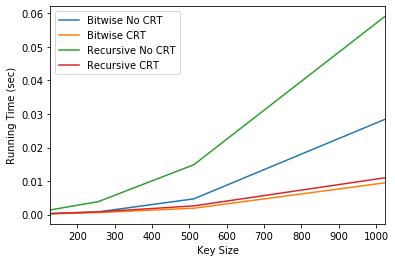

In [9]:
ax_4=rt_table_4.plot(x='Key Size', y=['Bitwise No CRT', 'Bitwise CRT', 'Recursive No CRT', 'Recursive CRT'], kind='line')
ax_4.set_ylabel("Running Time (sec)")
ax_4

In [12]:
rt_table_2=pd.DataFrame(list(zip(bit_lengths, reg_running_times_bit, CRT_running_times_bit)), columns=['Key Size','Bitwise No CRT', 'Bitwise CRT'])
rt_table_2

,Key Size,Bitwise No CRT,Bitwise CRT
0,128,0.000299,0.000199
1,256,0.000800,0.000601
2,512,0.004690,0.001895
3,1024,0.028424,0.009475
4,2048,0.195408,0.057594
5,4096,1.356546,0.390583


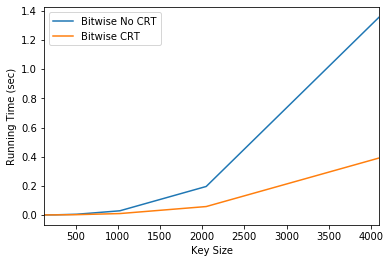

In [14]:
ax_2=rt_table_2.plot(x='Key Size', y=['Bitwise No CRT', 'Bitwise CRT'], kind='line')
ax_2.set_ylabel("Running Time (sec)")
ax_2

## The Random Fault Attack

It was also requested that we implement the random fault attack on the signature of RSA given in the following paper:
https://crypto.stanford.edu/~dabo/pubs/papers/RSA-survey.pdf 

This attack proceeds as follows:

Alice asks Bob to sign a message $m$. Normally, Bob signs the message with his private key $sk$. Alice can verify this signature $s$ using the public key $pk$. It is the same as the original message $m$. 

The random fault attack works on the CRT implementation of RSA decryption. With CRT, RSA signing/decrypting first sends the message $m$ in $Z_n$ to the corresponding element $(u, v)$ in $Z_p x Z_q$. Exponentiation is done in $Z_p x Z_q$ where it is less computationally expensive:

$$x= u^d (mod (p-1))$$

$$w=v^d (mod (q-1))$$

Afterwards, send $(x, w)$ in $Z_p x Z_q$ to the corresponding element in $Z_n$. This can be done using the Extended Euclidean Algorithm, where we find $r$ and $t$, the inverses of $p$ in $Z_q$, and $q$ in $Z_p$, respectively, so that:

$$rpx + tqw = w (mod p) = x (mod q)$$

is the corresponding element in $Z_n$. This is the signature $s = m ^ d (mod n)$.

Note that $spx = 0 (mod p)$ and $tqw = 0 (mod q)$. The random fault attack can be mounted if exactly one of $w$ or $x$ can be corrupted.

Suppose exactly one of $x$ or $w$ has bit errors, say $x$ becomes $x'$. Then Alice doesn't get the original message $m$ when she verifies the signature. Instead of $s^e (mod n) = m$, Alice gets: 

$$m' = (rpx' + tqw)^e (mod n)= (rpx')^e + (tpq)^e (mod n)$$

The difference between this and $m = s^d = (rpx) ^ e + (tpq) ^ e (mod n)$ is $(rpx') ^ e - (rpx)^e (mod n)$. This difference is equivalent to $0 (mod p)$, and just as important, this difference is nonzero. That is, $m - verify(s', public_key) = 0 (mod p)$ and is nonzero. Thus, computing $gcd(n, m - verify(s' public_key))$ reveals one of the factors of n. When we introduce even a single bit error in $x$ or $w$, we don't get the original message $m$ when we verify the corrupted signature.

In our implementation, the CRT_rsa_sign function has a 'feature' that lets us introduce a bit error at a random position in either $x$ or $w$. Alice won't get the original message back when she verifies $s$'. The difference between this corrupted message and the original message is equivalent to 0 modulo one of the prime factors of $n$. Alice can recover the factorization by computing the gcd. This factorization should be equal to one of the prime factors of n.

To demonstrate this, we present the following code. We use 1024 bits here for ease of computation.

In [ ]:
scheme = RSA(powmodn=bit_pow_mod_n, sign=True)

bit_length = 1024
e = 65537

print("\n\n-------------------------------------------------------------")
print("\nThe random fault attack:")
print("Generating", bit_length, "-bit keys...")

(p, q, n, l, e, d, public_key, private_key) = scheme.generate_keys(bit_length, e)

message = "Please attach your signature."
print("\n Message to be signed:\n\n\t", message)
m = string2int(message)

s = scheme.rsa_sign(m, private_key, p, q)
print("\n Signature creation successful!")

s1 = scheme.rsa_sign(m, private_key, p, q, faulty=True)  # random bit flip

print("\n Created corrupted signature \n")

m1 = scheme.rsa_verify(s1, public_key)

print("Are m and m' the same? \t", m1==m)

recovered_factor = gcd(n, m - m1)

print("Is recovered_factor=p?\t", recovered_factor==p)
print("Is recovered_factor=q?\t", recovered_factor==q)

We note here that $gcd(n, m - m')=p$, verifying the correctness of our fault attack implementation.

## The Timing Attack

In [ ]:
##To be implemented